## 大規模圖像檢索(Large-Scale Image Retrieval)

In [2]:
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
import pydegensac
from kornia_moons.feature import *
import os
from glob import glob
import faiss
import pandas as pd
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

### 步驟


#### 索引階段
1. 萃取索引圖像的特徵
2. 儲存特徵至資料庫
#### 查詢階段
1. 萃取查詢圖像的特徵
2. 索引圖像的特徵與查詢圖像的特徵匹配
3. 找出匹配度最高的幾張圖像


### 索引階段

#### 1. 萃取查詢圖像的特徵
* SIFT 
* AffineNet
* OriNet
* HardNet

In [2]:
sift_det =  cv2.SIFT_create(8000)
hardnet8 = KF.HardNet8(True).eval()
affnet = KF.LAFAffNetShapeEstimator(True).eval()
orienter = KF.LAFOrienter(32, angle_detector=KF.OriNet(True)).eval()

In [3]:
def feature_extract(fname, detector, affine, descriptor, orienter, visualize=False):
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if visualize:
        plt.imshow(img)
    kpts = detector.detect(img, None)
    with torch.no_grad():
        timg = K.image_to_tensor(img, False).float()/255.
        timg_gray = K.color.rgb_to_grayscale(timg)
        lafs = laf_from_opencv_SIFT_kpts(kpts)
        lafs_new = orienter(affine(lafs, timg_gray), timg_gray)
        if visualize:
            visualize_LAF(timg, lafs_new, 0)
        patches = KF.extract_patches_from_pyramid(timg_gray,lafs_new, 32)
        B, N, CH, H, W = patches.size()
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B * N, -1)
    return descs.detach().cpu().numpy(), kpts

#### 視覺化

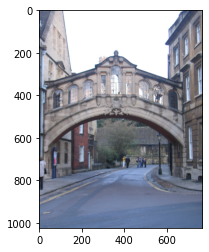

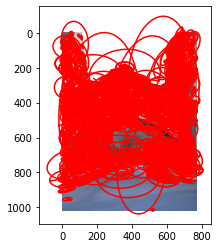

In [4]:
fname = 'index_ds/Hertford/hertford_000026.jpg'
kpts, descs = feature_extract(fname,  sift_det, affnet, hardnet8, orienter, True)

#### 2. 將所有索引圖像的特徵存放至numpy array
* db_index
* db_kpts
* db_desc
* db_label
* db_label_id
* db_fname

In [5]:
index_dir= 'index_ds'

In [6]:
db_index = np.array([0], dtype=np.uint32)
db_kpts = np.array([], dtype=np.object_)
db_desc = np.empty([0, 128], dtype=np.float32)
db_label = np.array([], dtype=np.str_)
db_label_id = np.array([], dtype=np.int64)
db_fname = np.array([], dtype=np.str_)
db_index_cnt = 0
idx_cnt = 0
total = len(glob(index_dir+'/*/*'))
for idx, folder in enumerate(sorted(glob(index_dir+'/*'))):
    label = os.path.basename(folder)
    for fname in glob(folder+'/*'):
        desc, kpts = feature_extract(fname,  sift_det, affnet, hardnet8, orienter)
        db_index_cnt = np.uint32(db_index_cnt + len(desc))
        db_index = np.append(db_index, db_index_cnt)
        db_kpts = np.append(db_kpts, kpts)
        db_desc = np.vstack([db_desc, desc])
        db_label = np.append(db_label, label)
        db_label_id = np.append(db_label_id, [idx]*len(desc))
        db_fname = np.append(db_fname, fname)
        idx_cnt = idx_cnt + 1

In [7]:
db = {"db_index":db_index, "db_kpts":db_kpts, "db_desc":db_desc, "db_label":db_label, "db_label_id": db_label_id, "db_fname":db_fname}

#### 使用faiss建立資料庫

* IVF
* PQ

In [8]:
d = 128
m = 128
nbits = 8
nlist = 50
db_learn = db['db_desc'][np.random.choice(db['db_desc'].shape[0], int(db['db_desc'].shape[0]/10), replace=False), :]
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, nbits)
index.train(db_learn)
index.add_with_ids(db['db_desc'], db['db_label_id'])

### 查詢階段

#### 1. 萃取查詢圖像特徵

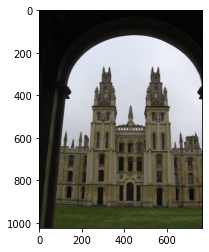

In [9]:
fname1 = 'query_ds/Allsouls/all_souls_000140.jpg'
img1 = cv2.cvtColor(cv2.imread(fname1), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

In [10]:
desc1, kpts1 = feature_extract(fname1,  sift_det, affnet, hardnet8, orienter)

#### 2. 特徵查詢

In [11]:
D, I = index.search(desc1, 100)
topk_arglist = np.argsort(np.bincount(I.flatten()))[::-1][:20]

#### 3. 使用pydegensac進行重新排序(Rerank)

In [12]:
def feature_matching(desc1, desc2, kpts1, kpts2):
    dists, idxs = KF.match_smnn(torch.from_numpy(desc1), torch.from_numpy(desc2), 0.95)
    tentatives = cv2_matches_from_kornia(dists, idxs)
    src_pts = np.float32([ kpts1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kpts2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    if (src_pts.shape[0] or dst_pts.shape[0]) < 8:
        return -1
    F, inliers_mask = pydegensac.findFundamentalMatrix(src_pts, dst_pts, 0.75, 0.99, 100000)
    inliers = inliers_mask.sum()
    return inliers

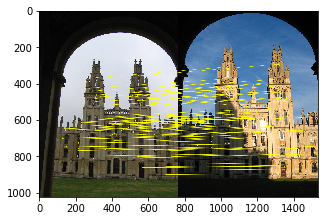

Matching top 1, filename: index_ds\Allsouls\all_souls_000015.jpg, label: Allsouls, inliers = 82


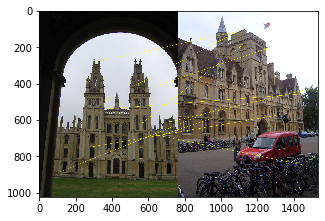

Matching top 2, filename: index_ds\Balliol\balliol_000051.jpg, label: Balliol, inliers = 10


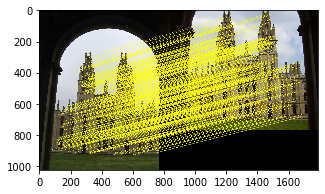

Matching top 3, filename: index_ds\Allsouls\all_souls_000091.jpg, label: Allsouls, inliers = 437


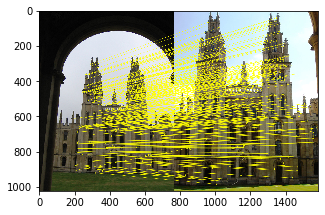

Matching top 4, filename: index_ds\Allsouls\all_souls_000026.jpg, label: Allsouls, inliers = 275


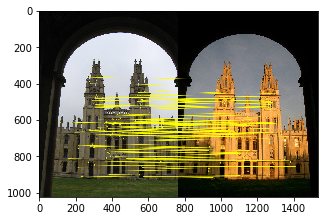

Matching top 5, filename: index_ds\Allsouls\all_souls_000055.jpg, label: Allsouls, inliers = 140
預測的類別:Allsouls 


In [13]:
df = pd.DataFrame(columns=["filename", "label", "inliers"])
for idx, arg in enumerate(topk_arglist):
    kpts2 = db["db_kpts"][db["db_index"][arg] : db["db_index"][arg + 1]]
    desc2 = db["db_desc"][db["db_index"][arg] : db["db_index"][arg + 1]]
    label2 = db["db_label"][arg]
    fname2 = db["db_fname"][arg]
    dists, idxs = KF.match_smnn(
        torch.from_numpy(desc1), torch.from_numpy(desc2), 0.95
    )
    tentatives = cv2_matches_from_kornia(dists, idxs)
    src_pts = np.float32([kpts1[m.queryIdx].pt for m in tentatives]).reshape(-1, 2)
    dst_pts = np.float32([kpts2[m.trainIdx].pt for m in tentatives]).reshape(-1, 2)
    if (src_pts.shape[0] or dst_pts.shape[0]) < 8:
        continue
    F, inliers_mask = pydegensac.findFundamentalMatrix(
            src_pts, dst_pts, 0.75, 0.99, 100000
        )
    inliers = inliers_mask.sum()
    img2 = cv2.cvtColor(cv2.imread(fname2), cv2.COLOR_BGR2RGB)
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = inliers_mask.ravel().tolist(), # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(img1,kpts1,img2,kpts2,tentatives,None,**draw_params)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img_out, interpolation='nearest')
    plt.show()
    print(
        "Matching top {}, filename: {}, label: {}, inliers = {}".format(
                idx + 1, fname2, label2, inliers
            )
    )
    row = pd.DataFrame(
        [[fname2, label2, inliers]], columns=["filename", "label", "inliers"]
    )
    df = pd.concat([df, row])
df = df.sort_values(by=["inliers"], ascending=False).head(5)
pred = df.head(1).label[0]
print('預測的類別:{} '.format(pred))

#### 4. 用閾值來判定查詢圖像是否在索引類別內

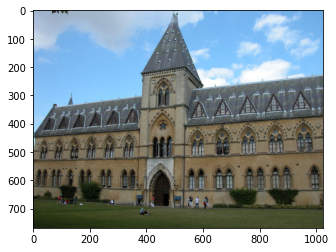

In [14]:
fname1 = 'query_ds/Pitt_rivers/pitt_rivers_000119.jpg'
img1 = cv2.cvtColor(cv2.imread(fname1), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

In [15]:
desc1, kpts1 = feature_extract(fname1,  sift_det, affnet, hardnet8, orienter)

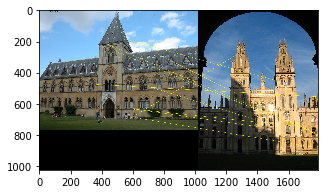

Matching top 1, filename: index_ds\Allsouls\all_souls_000015.jpg, label: Allsouls, inliers = 10


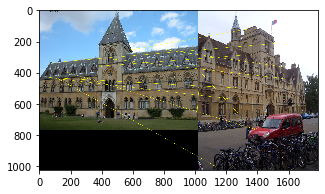

Matching top 2, filename: index_ds\Balliol\balliol_000051.jpg, label: Balliol, inliers = 11


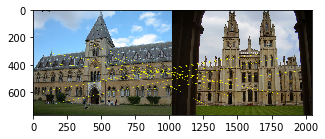

Matching top 3, filename: index_ds\Allsouls\all_souls_000091.jpg, label: Allsouls, inliers = 10


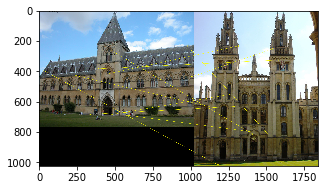

Matching top 4, filename: index_ds\Allsouls\all_souls_000026.jpg, label: Allsouls, inliers = 10


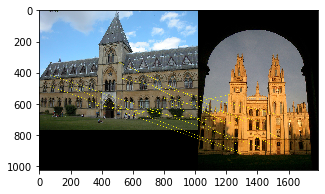

Matching top 5, filename: index_ds\Allsouls\all_souls_000055.jpg, label: Allsouls, inliers = 10
預測的類別: 不在索引分類裡面


In [16]:
df = pd.DataFrame(columns=["filename", "label", "inliers"])
for idx, arg in enumerate(topk_arglist):
    kpts2 = db["db_kpts"][db["db_index"][arg] : db["db_index"][arg + 1]]
    desc2 = db["db_desc"][db["db_index"][arg] : db["db_index"][arg + 1]]
    label2 = db["db_label"][arg]
    fname2 = db["db_fname"][arg]
    dists, idxs = KF.match_smnn(
        torch.from_numpy(desc1), torch.from_numpy(desc2), 0.95
    )
    tentatives = cv2_matches_from_kornia(dists, idxs)
    src_pts = np.float32([kpts1[m.queryIdx].pt for m in tentatives]).reshape(-1, 2)
    dst_pts = np.float32([kpts2[m.trainIdx].pt for m in tentatives]).reshape(-1, 2)
    if (src_pts.shape[0] or dst_pts.shape[0]) < 8:
        continue
    F, inliers_mask = pydegensac.findFundamentalMatrix(
            src_pts, dst_pts, 0.75, 0.99, 100000
        )
    inliers = inliers_mask.sum()
    img2 = cv2.cvtColor(cv2.imread(fname2), cv2.COLOR_BGR2RGB)
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = inliers_mask.ravel().tolist(), # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(img1,kpts1,img2,kpts2,tentatives,None,**draw_params)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img_out, interpolation='nearest')
    plt.show()
    print(
        "Matching top {}, filename: {}, label: {}, inliers = {}".format(
                idx + 1, fname2, label2, inliers
            )
    )
    row = pd.DataFrame(
        [[fname2, label2, inliers]], columns=["filename", "label", "inliers"]
    )
    df = pd.concat([df, row])
if df['inliers'].max() < 20:
    print('預測的類別: 不在索引分類裡面')
else:
    df = df.sort_values(by=["inliers"], ascending=False).head(5)
    pred = df.head(1).label[0]
    print('預測的類別:{} '.format(pred))